In [2]:
import sys
import os
sys.path.insert(0, os.path.join(os.path.abspath(os.path.dirname(sys.argv[0])),
                                os.pardir))
sys.path.append('../..')
sys.path.append('../../scripts')
from explainn import tools
from explainn import networks
from explainn import train
from explainn import test
from explainn import interpretation

from explainn.interpretation.interpretation import get_explainn_predictions

import torch
import os
from torch import nn
from sklearn.metrics import average_precision_score
from sklearn import metrics
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from explainn.interpretation.interpretation import get_explainn_predictions
from explainn.models.networks import ExplaiNN
# insert to sys path the second parent directory of the current script
# to be able to import the utils file
import sys
sys.path.insert(0, os.path.join(os.path.abspath(os.path.dirname(sys.argv[0])),
                                os.pardir, os.pardir))
from scripts.utils import (get_file_handle, get_seqs_labels_ids, get_data_loader,get_device)

In [3]:
sys.path

['c:\\Users\\aslak\\anaconda3\\envs\\testy\\Lib\\site-packages\\..\\..',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\Lib\\site-packages\\..',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\python312.zip',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\DLLs',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\Lib',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy',
 '',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\Lib\\site-packages',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\Lib\\site-packages\\win32',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\Lib\\site-packages\\win32\\lib',
 'c:\\Users\\aslak\\anaconda3\\envs\\testy\\Lib\\site-packages\\Pythonwin',
 '../..',
 '../../scripts']

# Train the ExplaiNN model on TF binding sites 

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Parameters
num_epochs = 2
batch_size = 100
learning_rate = 0.005 

# dataloaders2, target_labels2, train_out2 = tools.load_datas("../../data/test/tf_peaks_TEST_sparse_Remap.h5", batch_size,
#                                                          0, True)
dataloaders, target_labels, train_out = tools.load_datas("../../../SCRATCH/AS-TAC/AS-TAC__.h5", batch_size,
                                                         0, True)

target_labels = [i.decode("utf-8") for i in target_labels]
# target_labels2 = [i.decode("utf-8") for i in target_labels2]

num_cnns = 100
input_length = 1000
num_classes = len(target_labels)
filter_size = 19

cnn_deep = networks.ConvNetDeep(num_classes)
cnn_shallow = networks.ConvNetShallow(num_classes)
#danq = networks.DanQ(num_classes)
explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(explainn.parameters(), lr=learning_rate)

weights_folder = "../../../SCRATCH/AS-TAC/ExplaiNN/single_train/JOB_ID/"
#os.makedirs(weights_folder)
name_ind = ""

Dataset Loaded


In [5]:
# training an individual model with 100 units
explainn_100, train_error, test_error = train.train_explainn(dataloaders['train'], dataloaders['valid'], explainn,
                                                device, criterion, optimizer, num_epochs,
                                                weights_folder, name_ind, verbose=True, trim_weights=False)

Epoch [1], Current Train Loss: 0.70605, Current Val Loss: 0.66067
Epoch [2], Current Train Loss: 0.59440, Current Val Loss: 0.64460
Epoch [3], Current Train Loss: 0.52615, Current Val Loss: 0.63688
Epoch [4], Current Train Loss: 0.46452, Current Val Loss: 0.62304
Epoch [5], Current Train Loss: 0.40992, Current Val Loss: 0.60542
Epoch [6], Current Train Loss: 0.36243, Current Val Loss: 0.59255
Epoch [7], Current Train Loss: 0.32258, Current Val Loss: 0.58103
Epoch [8], Current Train Loss: 0.29100, Current Val Loss: 0.56433
Epoch [9], Current Train Loss: 0.26619, Current Val Loss: 0.53915
Epoch [10], Current Train Loss: 0.24726, Current Val Loss: 0.50362
Epoch [11], Current Train Loss: 0.23200, Current Val Loss: 0.46242
Epoch [12], Current Train Loss: 0.21903, Current Val Loss: 0.42417
Epoch [13], Current Train Loss: 0.20871, Current Val Loss: 0.39169
Epoch [14], Current Train Loss: 0.19934, Current Val Loss: 0.36591
Epoch [15], Current Train Loss: 0.19019, Current Val Loss: 0.34765
Epoc

<Figure size 640x480 with 0 Axes>

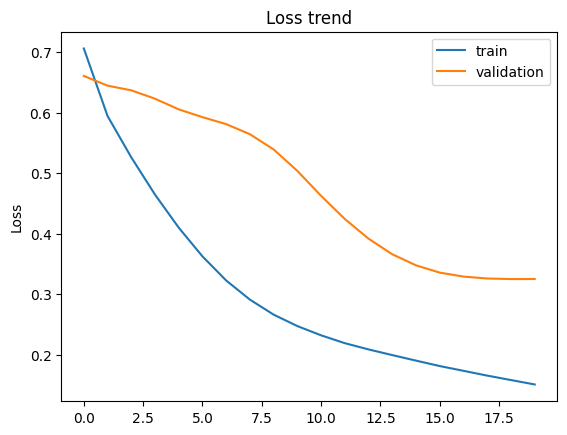

In [6]:
%matplotlib inline
tools.showPlot(train_error, test_error, "Loss trend", "Loss")

In [7]:
import tqdm
# Code to test how performance depends of the number of units
num_classes = len(target_labels) #number of classes
learning_rate = 0.01
num_epochs = 50
input_length = 1000
for num_cnns in range(25,126,50):
    if num_cnns == 0:
        num_cnns = 1    

    explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(explainn.parameters(), lr=learning_rate)
    
    os.makedirs("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns))
    
    model, train_error, test_error = train.train_explainn(dataloaders['train'], dataloaders['valid'], explainn,
                                                device, criterion, optimizer, num_epochs,
                                                "../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)
                                                          , name_ind, verbose=True, trim_weights=False, checkpoint=False)
    
#old dir: ExplaiNN_filters_TF_binding/ExplaiNN_TF_num_cnns_
    print("Numm_cnns: " + str(num_cnns))
    print("Min test error: " + str(np.min(test_error)))

# testing
auprc_perf = {}
num_classes = len(target_labels)
for num_cnns in range(25,126,50):
    if num_cnns == 0:
        num_cnns = 1
    
    model = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
    
    #load the best model
    #old dir: CAM_filters_TF_binding/CAM_TF_num_cnns_
    #find the file that contains "best" in its name in the dir os.listdir("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/")

    weight_file = os.listdir("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/")[0]
    
    model.load_state_dict(torch.load("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/"+weight_file))
    model.eval();

    labels_E, outputs_E = test.run_test(model, dataloaders['test'], device)
    
    auprc_perf[num_cnns] = average_precision_score(labels_E, outputs_E)
    
auprc_perf = pd.Series(auprc_perf)  

FileExistsError: [WinError 183] Kan ikke opprette en fil når filen allerede finnes: '../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_25'

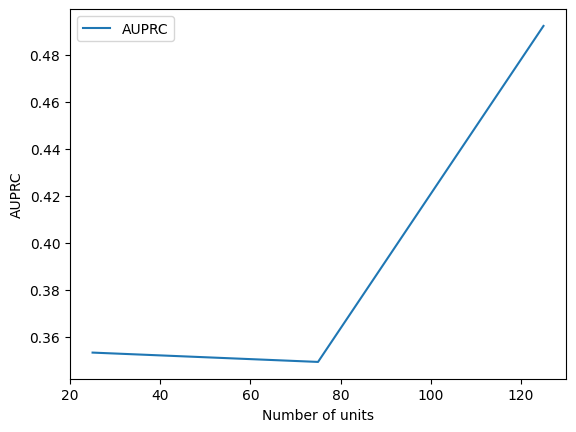

In [ ]:
#plot auprc_perf with respect to the number of units and show legend and save the plot
plt.plot(auprc_perf)
plt.xlabel("Number of units")
plt.ylabel("AUPRC")
plt.legend(["AUPRC"])
plt.savefig("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/AUPRC_num_units.png")

In [ ]:
explainn_100 = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(explainn_100.parameters(), lr=learning_rate)
#weight_file

In [ ]:
# performances for individual TFs (classes)
explainn_100.eval()

# Get test sequences and labels
seqs, labels, _ = get_seqs_labels_ids("../../../SCRATCH/AS-TAC/AS-TAC_1000bp.tsv.validation", target_labels, False, 1000)

# Get training DataLoader
data_loader = get_data_loader(seqs, labels, 100)


labels_E, outputs_E = test.run_test(explainn_100, data_loader, device)

no_skill_probs = [0 for _ in range(len(labels_E[:,0]))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(labels_E[:,0], no_skill_probs)

roc_aucs = {}
raw_aucs = {}
roc_prcs = {}
raw_prcs = {}
for i in range(len(target_labels)):
    nn_fpr, nn_tpr, threshold = metrics.roc_curve(labels_E[:,i], outputs_E[:,i])
    roc_auc_nn = metrics.auc(nn_fpr, nn_tpr)
    
    precision_nn, recall_nn, thresholds = metrics.precision_recall_curve(labels_E[:,i], outputs_E[:,i])
    pr_auc_nn = metrics.auc(recall_nn, precision_nn)
    
    roc_aucs[target_labels[i]] = nn_fpr, nn_tpr
    raw_aucs[target_labels[i]] = roc_auc_nn
    
    roc_prcs[target_labels[i]] = recall_nn, precision_nn
    raw_prcs[target_labels[i]] = pr_auc_nn
    
raw_prcs_explainn = pd.Series(raw_prcs)
raw_aucs_explainn = pd.Series(raw_aucs)

In [ ]:
# view the keys of the dataloader data_loder
data_loader.keys()
data_loader

AttributeError: 'DataLoader' object has no attribute 'keys'

In [3]:
explainn_100.eval()

NameError: name 'explainn_100' is not defined

In [ ]:
# AUPRC
# The TFs index object has the target labels. And within the 63 labes, I want to color by labels containing the words "Brain", "Liver", "Gonad", "Muscle", "MidSomitogenesis", "LateSomitogenesis", "Lateblastulation", "EarlySomitogenesis_R2"
# I will use the seaborn library to color the bars

# make a new column that is the first word before "_" in the rownames of the Series object turned into a df
df = raw_prcs_explainn.reset_index()
df['tissue'] = df['index'].str.split('_').str[0]



TFs = raw_prcs_explainn.index[:63]
AUPRC = raw_prcs_explainn.values[:63]
#make the sns.barplot bigger

sns.barplot(x=TFs, y=AUPRC, hue=df['tissue'], palette="tab10")
plt.savefig('sns_test.png')

NameError: name 'raw_prcs_explainn' is not defined

In [ ]:
filtered_df = df[df[0] < 0.2]
print(filtered_df)


                       index         0              tissue
12    Gonad_Immature_Male_R1  0.173791               Gonad
14       LateBlastulation_R3  0.121275    LateBlastulation
15     EarlySomitogenesis_R1  0.187598  EarlySomitogenesis
16       MidSomitogenesis_R3  0.078968    MidSomitogenesis
19    Liver_Immature_Male_R3  0.065211               Liver
24      LateSomitogenesis_R2  0.123843   LateSomitogenesis
30      Liver_Mature_Male_R3  0.196448               Liver
31   Muscle_Mature_Female_R2  0.147727              Muscle
43       LateBlastulation_R2  0.140422    LateBlastulation
51     Muscle_Mature_Male_R2  0.150673              Muscle
54  Liver_Immature_Female_R3  0.175595               Liver
56       LateBlastulation_R1  0.101705    LateBlastulation
58    Gonad_Immature_Male_R2  0.195833               Gonad
62     EarlySomitogenesis_R2  0.134040  EarlySomitogenesis


In [ ]:
print(TFs)

Index(['Liver_Mature_Male_R1', 'MidSomitogenesis_R1',
       'Muscle_Immature_Female_R3', 'Muscle_Mature_Male_R3',
       'LateSomitogenesis_R3', 'Liver_Immature_Female_R1',
       'Gonad_Immature_Female_R3', 'MidGastrulation_R3', 'MidGastrulation_R1',
       'Muscle_Mature_Female_R3', 'LateSomitogenesis_R1',
       'Brain_Immature_Male_R2', 'Gonad_Immature_Male_R1',
       'Liver_Immature_Female_R2', 'LateBlastulation_R3',
       'EarlySomitogenesis_R1', 'MidSomitogenesis_R3',
       'Liver_Mature_Female_R3', 'Brain_Mature_Male_R1',
       'Liver_Immature_Male_R3', 'Liver_Mature_Female_R2',
       'Brain_Immature_Male_R3', 'Brain_Immature_Female_R3',
       'Gonad_Immature_Female_R2', 'LateSomitogenesis_R2',
       'Brain_Mature_Female_R2', 'Gonad_Mature_Female_R3',
       'Brain_Mature_Male_R2', 'EarlySomitogenesis_R3',
       'Brain_Immature_Male_R1', 'Liver_Mature_Male_R3',
       'Muscle_Mature_Female_R2', 'Muscle_Immature_Female_R1',
       'Brain_Immature_Female_R2', 'Brain_Matu

# Interpretation

In [11]:
num_cnns=100
explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size, num_fc = 2).to(device)

#weight_file = os.listdir("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/")[0]

#explainn.load_state_dict(torch.load("../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/"+weight_file))
explainn.eval()
    

ExplaiNN(
  (linears): Sequential(
    (0): Conv1d(400, 100, kernel_size=(19,), stride=(1,), groups=100)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(14000, 10000, kernel_size=(1,), stride=(1,), groups=100)
    (7): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(10000, 100, kernel_size=(1,), stride=(1,), groups=100)
    (11): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=100, out_features=63, bias=True)
)

In [5]:
#explainn
#"../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_"+str(num_cnns)+"/"+weight_file
data_inp.shape

torch.Size([50000, 4, 1000])

In [3]:
batch_size = 100
dataset, data_inp, data_out = tools.load_single_data("../../../SCRATCH/AS-TAC/AS-TAC_50K.h5", batch_size, 1, False)
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=True)

# only well predicted sequences
pred_full_round = np.round(predictions)
arr_comp = np.equal(pred_full_round, labels)
idx = np.argwhere(np.sum(arr_comp, axis=1) == len(target_labels)).squeeze()

data_inp = data_inp[idx, :, :]
data_out = data_out[idx, :]

dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, shuffle=False,
                                                  num_workers=0)

activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
pwms = interpretation.get_pwms_explainn(activations, data_inp, filter_size)
interpretation.pwm_to_meme(pwms, "../../../SCRATCH/AS-TAC/ASSY.meme")

NameError: name 'explainn' is not defined

In [ ]:
#explore my torch.utils.data.dataset.TensorDataset object "dataset"
dataset.tensors[0].shape

In [ ]:
%%bash

./../../../meme-5.3.3/src/tomtom -o ../../../SCRATCH/AS-TAC/ExplaiNN/single_train/ExplaiNN_TF_num_cnns_$num_cnns data/TFBS.meme ../../../SCRATCH/downloads/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt

In [ ]:
tomtom_results = pd.read_csv(f"../../../tomtom_results/tomtom_TF_binding/tomtom_CAM_{num_cnns}/tomtom.tsv",
                                        sep="\t",comment="#")

filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]

tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

cisbp_motifs = {}
with open("../../../tomtom_results/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation

In [ ]:
weights = explainn.final.weight.detach().cpu().numpy()

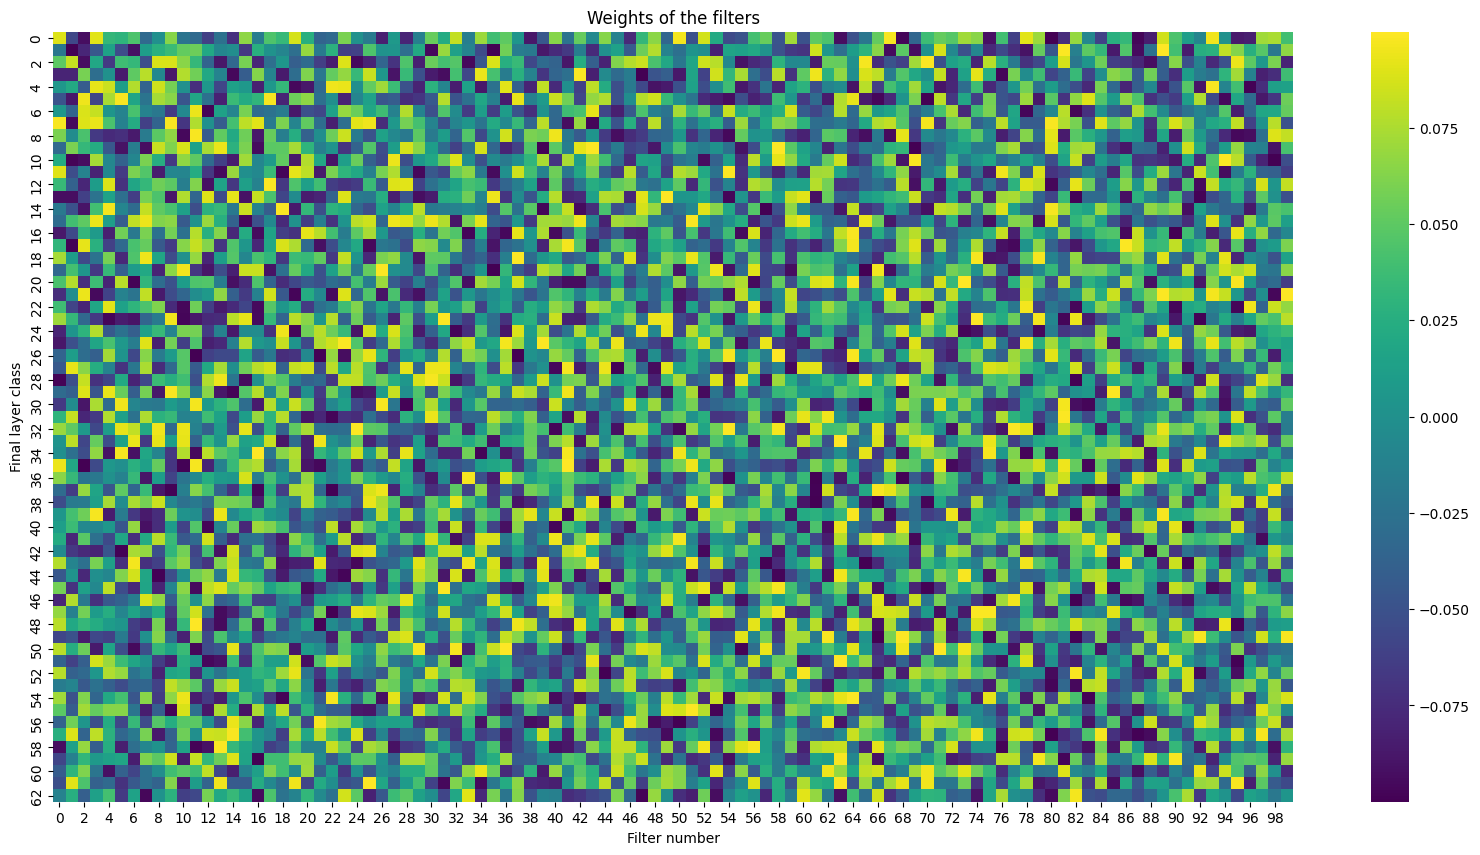

In [ ]:
# make a heatmap of weights, y axis is the filter number, x axis is the position in the filter
plt.figure(figsize=(20,10))
sns.heatmap(weights, cmap="viridis")
plt.ylabel("Final layer class")
plt.xlabel("Filter number")
plt.title("Weights of the filters")
plt.show()

In [ ]:
weights = explainn.final.weight.detach().cpu().numpy()

filters = ["filter"+str(i) for i in range(num_cnns)]
for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]
    
weight_df = pd.DataFrame(weights,index=target_labels,columns=filters)
weight_df.shape

NameError: name 'annotation' is not defined

In [ ]:
sns.clustermap(weight_df,cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)

In [ ]:
#only annotated columns
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]

clust = sns.clustermap(ann_wdf, cmap='vlag',#cmap=sns.diverging_palette(145, 10, s=60, as_cmap=True), 
               row_cluster=True, figsize=(30,20), vmax=0.5, vmin = -0.5)

## Importance scores

In [ ]:
unit_outputs = interpretation.get_explainn_unit_outputs(dataloaders['valid'], explainn, device)

unit_importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, 19, target_labels)

filter_key = "filter"+str(19)
title = annotation[filter_key] if filter_key in annotation.index else filter_key
fig, ax = plt.subplots()
datas = [filt_dat for filt_dat in unit_importance]
ax.boxplot(datas, notch=True, patch_artist=True, boxprops=dict(facecolor="#228833", color="#228833"))
fig.set_size_inches(18.5, 10.5)
plt.title(title)
plt.ylabel("Unit importance")
plt.xticks(range(1, len(target_labels)+1), target_labels)
plt.xticks(rotation=90)
plt.show()

NameError: name 'activations' is not defined

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model_dir = "../../../SCRATCH/AS-TAC/ExplaiNN/single_train/num_cnns_100_14485214"
model_dir_list = os.listdir(model_dir)

# find the .pth file in weight_file list
for file in model_dir_list:
    if file.endswith(".pth"):
        weight_file = file
        break

In [9]:
num_cnns = 100
input_length = 1000
num_classes = 63
filter_size = 19

explainn = networks.ExplaiNN(num_cnns, input_length, num_classes, filter_size).to(device)
explainn.load_state_dict(torch.load(model_dir + "/" + weight_file, map_location=torch.device('cpu')))
explainn.eval();

In [10]:
# performances for individual TFs (classes)
explainn.eval()
labels_E, outputs_E = test.run_test(explainn, dataloaders['test'], device)

no_skill_probs = [0 for _ in range(len(labels_E[:,0]))]
ns_fpr, ns_tpr, _ = metrics.roc_curve(labels_E[:,0], no_skill_probs)

roc_aucs = {}
raw_aucs = {}
roc_prcs = {}
raw_prcs = {}
for i in range(len(target_labels)):
    nn_fpr, nn_tpr, threshold = metrics.roc_curve(labels_E[:,i], outputs_E[:,i])
    roc_auc_nn = metrics.auc(nn_fpr, nn_tpr)
    
    precision_nn, recall_nn, thresholds = metrics.precision_recall_curve(labels_E[:,i], outputs_E[:,i])
    pr_auc_nn = metrics.auc(recall_nn, precision_nn)
    
    roc_aucs[target_labels[i]] = nn_fpr, nn_tpr
    raw_aucs[target_labels[i]] = roc_auc_nn
    
    roc_prcs[target_labels[i]] = recall_nn, precision_nn
    raw_prcs[target_labels[i]] = pr_auc_nn
    
raw_prcs_explainn = pd.Series(raw_prcs)
raw_aucs_explainn = pd.Series(raw_aucs)

c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:993: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\aslak\anaconda3\envs\testy\Lib\site-packages\sklearn\metrics\_ranking.py:1146: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
c:\Users

In [11]:
df

NameError: name 'df' is not defined

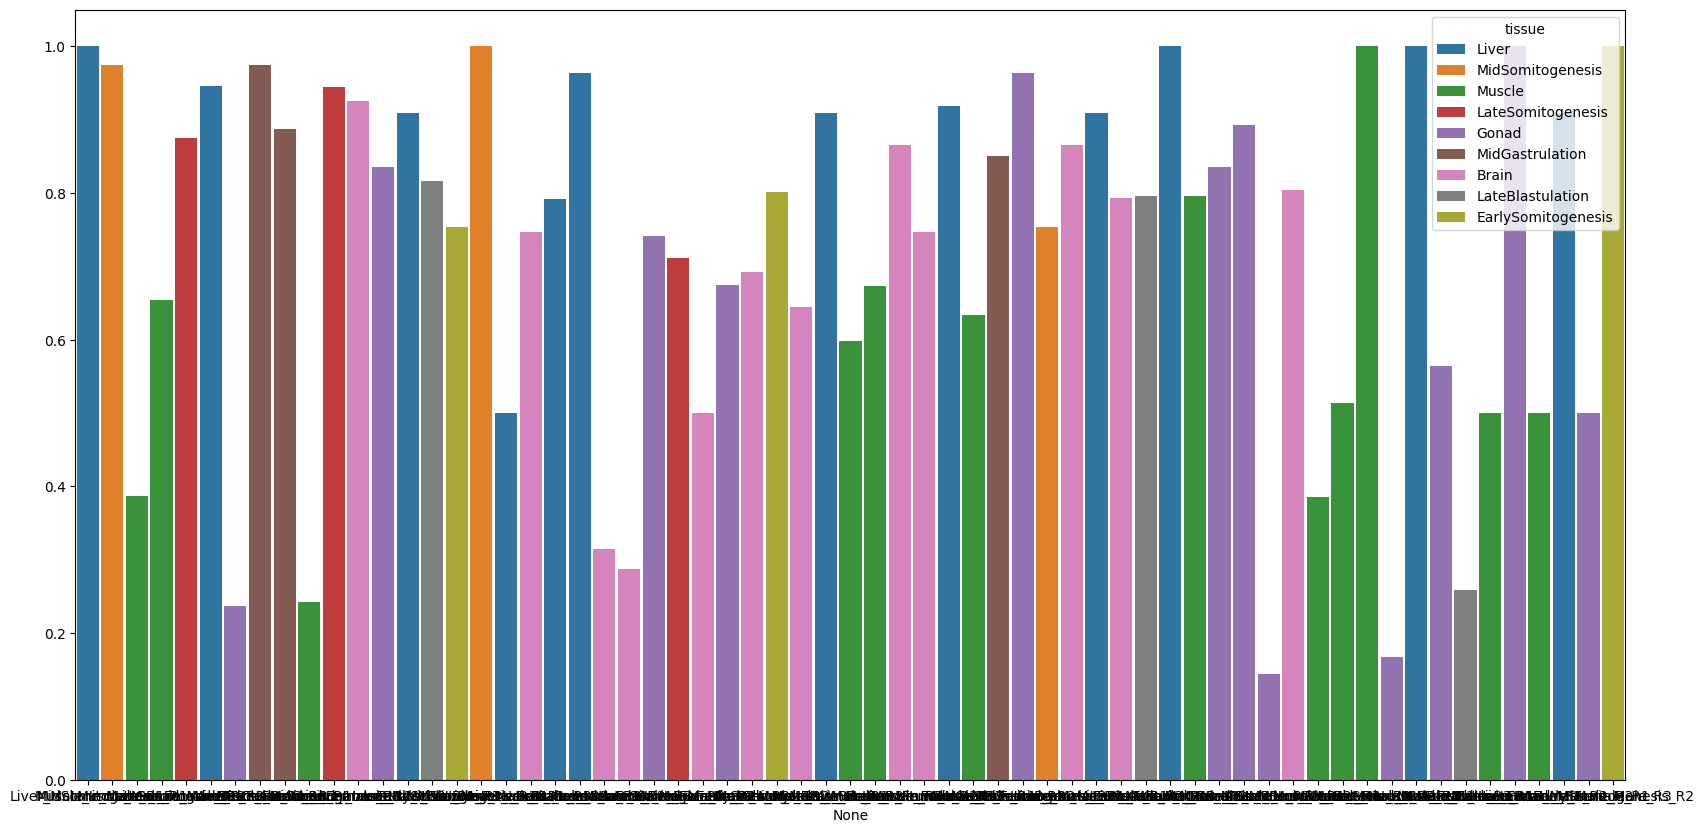

In [15]:
# AUPRC
# The TFs index object has the target labels. And within the 63 labes, I want to color by labels containing the words "Brain", "Liver", "Gonad", "Muscle", "MidSomitogenesis", "LateSomitogenesis", "Lateblastulation", "EarlySomitogenesis_R2"
# I will use the seaborn library to color the bars

# make a new column that is the first word before "_" in the rownames of the Series object turned into a df
df = raw_prcs_explainn.reset_index()
df['tissue'] = df['index'].str.split('_').str[0]



TFs = raw_prcs_explainn.index
AUPRC = raw_prcs_explainn.values
#make the sns.barplot bigger
plt.figure(figsize=(20,10))
sns.barplot(x=TFs, y=AUPRC, hue=df['tissue'], palette="tab10", width=0.9)
plt.savefig('sns_test.png')

In [ ]:
labels.shape[1]

63